# **Save this file as studentid1_studentid2_lab2.ipynb**
(Your student-id is the number shown on your student card.)

E.g. if you work with 2 people, the notebook should be named:
12301230_3434343_lab2.ipynb.

**IMPORTANT: This will be parsed by a regexp, so please double check your filename.**

**Only one member of each group has to submit the file to canvas.**

Before you turn this problem in, please make sure everything runs correctly. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All). Note, that **you are not allowed to use Google Colab**.

**Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".**

**Finally, add your names and email adresses below.**



NAME = "Marcello Barylli" 

NAME2 = Paula Antequera Hernández 

EMAIL = "marcello.barylli@student.uva.nl" 

EMAIL2 = paula.antequera.hernandez@student.uva.nl 

## Lab assignment 2: Gaussian Processes and Support Vector Machines

### Machine Learning 1, October 2022

Notes on implementation:

* You should write your code and answers in this IPython Notebook: http://ipython.org/notebook.html. If you have problems, please contact your teaching assistant.
* Please write your answers right below the questions.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* Refer to last week's lab notes, i.e. http://docs.scipy.org/doc/, if you are unsure about what function to use. There are different correct ways to implement each problem!
* use the provided test boxes to check if your answers are correct
* **Do not change the arugments in our functions!**
* **Do not remove add new cells. If you do you should expect a penalty in your assignment!**

In [1]:
%pylab inline
plt.rcParams["figure.figsize"] = [20,10]

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# This cell makes sure that you have all the necessary libraries installed

import sys
import platform
from importlib.util import find_spec, module_from_spec

def check_newer_version(version_inst, version_nec):
    version_inst_split = version_inst.split('.')
    version_nec_split = version_nec.split('.')
    for i in range(min(len(version_inst_split), len(version_nec_split))):
        if int(version_nec_split[i]) > int(version_inst_split[i]):
            return False
        elif int(version_nec_split[i]) < int(version_inst_split[i]):
            return True
    return True
        
    
module_list = [('jupyter', '1.0.0'), 
               ('matplotlib', '2.0.2'), 
               ('numpy', '1.13.1'), 
               ('python', '3.6.2'), 
               ('sklearn', '0.19.0'), 
               ('scipy', '0.19.1'), 
               ('nb_conda', '2.2.1')]

packages_correct = True
packages_errors = []

for module_name, version in module_list:
    if module_name == 'scikit-learn':
        module_name = 'sklearn'
    if module_name == 'pyyaml':
        module_name = 'yaml'
    if 'python' in module_name:
        python_version = platform.python_version()
        if not check_newer_version(python_version, version):
            packages_correct = False
            error = f'Update {module_name} to version {version}. Current version is {python_version}.'
            packages_errors.append(error) 
            print(error)
    else:
        spec = find_spec(module_name)
        if spec is None:
            packages_correct = False
            error = f'Install {module_name} with version {version} or newer, it is required for this assignment!'
            packages_errors.append(error) 
            print(error)
        else:
            x = __import__(module_name)
            if hasattr(x, '__version__') and not check_newer_version(x.__version__, version):
                packages_correct = False
                error = f'Update {module_name} to version {version}. Current version is {x.__version__}.'
                packages_errors.append(error) 
                print(error)

try:
    from google.colab import drive
    packages_correct = False
    error = """Please, don't use google colab!
It will make it much more complicated for us to check your homework as it merges all the cells into one."""
    packages_errors.append(error) 
    print(error)
except:
    pass

packages_errors = '\n'.join(packages_errors)

## Part 1: Gaussian Processes

For part 1 we will be refer to Bishop sections 6.4.2 and 6.4.3. You may also want to refer to Rasmussen's Gaussian Process text which is available online at http://www.gaussianprocess.org/gpml/chapters/ and especially to the project found at https://www.automaticstatistician.com/index/ by Ghahramani for some intuition in GP.  To understand Gaussian processes, it is highly recommended understand how marginal, partitioned Gaussian distributions can be converted into conditional Gaussian distributions.  This is covered in Bishop 2.3 and summarized in Eqns 2.94-2.98.
$\newcommand{\bt}{\mathbf{t}}$
$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\ba}{\mathbf{a}}$

### Periodic Data

We will use the same data generating function that we used previously for regression.

In [3]:
def true_mean_function(x):
    return np.sin(2*pi*(x+1))

def add_noise(y, sigma):
    return y + sigma*np.random.randn(len(y))

def generate_t(x, sigma):
    return add_noise(true_mean_function(x), sigma)


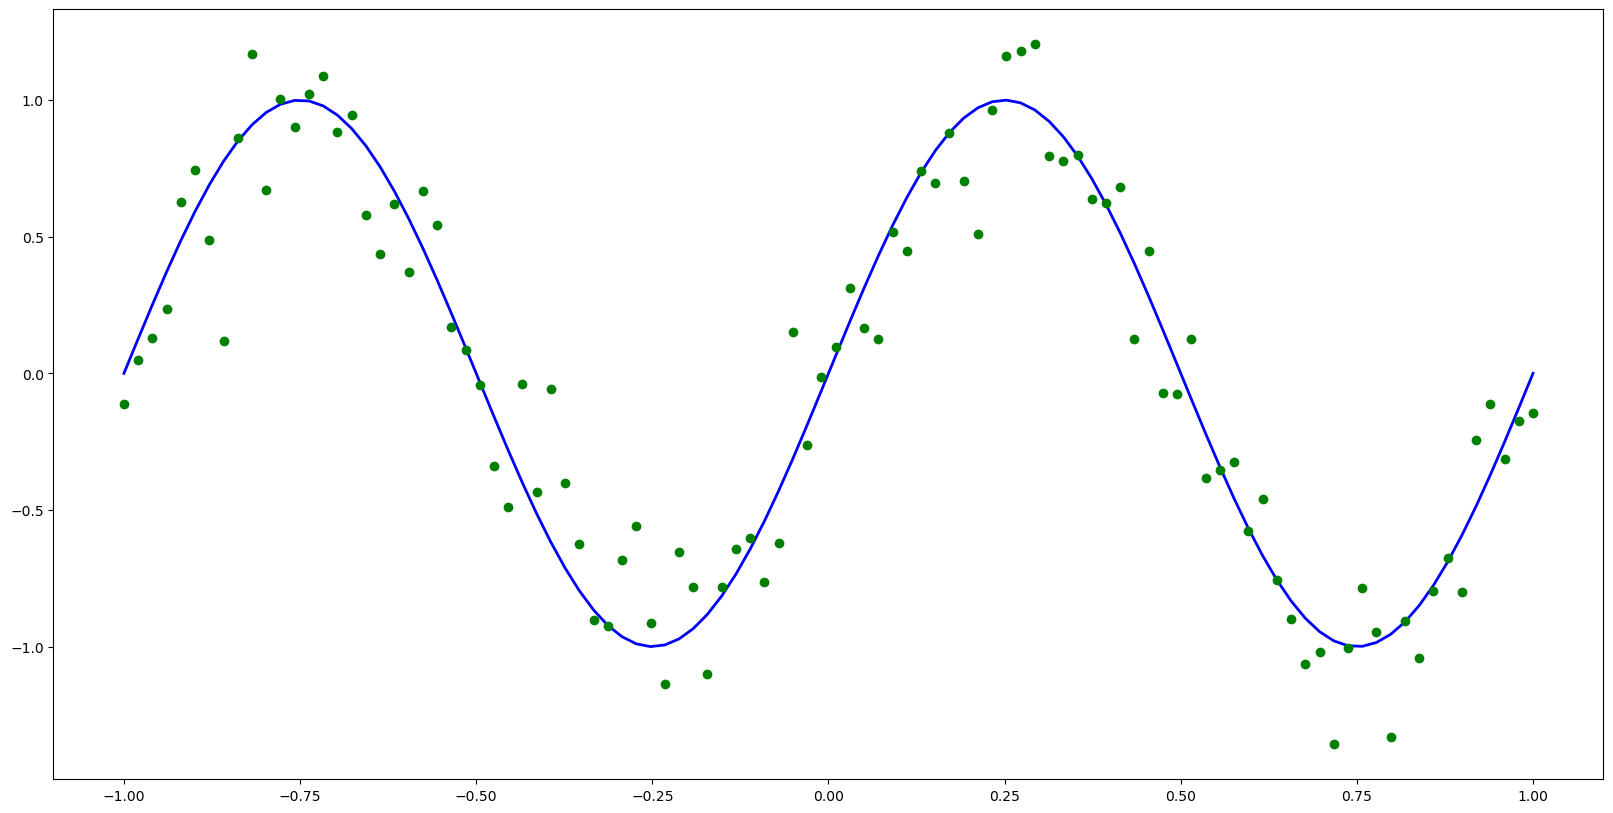

In [4]:
sigma = 0.2
beta  = 1.0 / pow(sigma, 2)
N_test = 100

x_test = np.linspace(-1, 1, N_test) 
mu_test = np.zeros(N_test)
y_test = true_mean_function(x_test)
t_test = add_noise(y_test, sigma)

plt.plot( x_test, y_test, 'b-', lw=2)
plt.plot( x_test, t_test, 'go')
plt.show()

### 1. Sampling from the Gaussian process prior (30 points)
We will implement Gaussian process regression using the kernel function in Bishop Eqn. 6.63.  

#### 1.1 Why kernel function? (5 points)

Before implementing kernel function, it would be useful to understand why kernels are crucial for high dimensional data. Why are kernels useful when you are dealing with high dimensional data?

In the basis function model we must invert a matrix of size $M \times M$, with M being the dimension of our datapoints $x_n$. Using a kernel matrix to descibe the covariance between 2 points $x_n$ and $x_m$, the resulting gram matrix is of size $N \times N$, N being the number of datapoints. 

Hence the step of inverting changes in cost from $O(M^3)$ to $O(N^3)$.

#### 1.2 k_n_m( xn, xm, thetas ) (5 points)
To start, implement function `k_n_m(xn, xm, thetas)` that takes scalars $x_n$ and $x_m$, and a vector of $4$ thetas, and computes the kernel function Bishop Eqn. 6.63 (10 points).  NB: usually the kernel function will take $D$ by $1$ vectors, but since we are using a univariate problem, this makes things easier.

In [5]:
def k_n_m(xn, xm, thetas):

    th_0,th_1,th_2,th_3 = thetas

    k = th_0*np.exp(-(th_1/2)*np.abs(xn - xm)**2) + th_2 + th_3*xn*xm
    
    return k

In [6]:
# DO NOT REMOVE THIS CELL!
# It contains hidden tests


#### 1.3 computeK( X1, X2, thetas ) (10 points)
Eqn 6.60 is the marginal distribution of mean output of $N$ data vectors: $p(\mathbf{y}) = \mathcal{N}(0, \mathbf{K})$.  Notice that the expected mean function is $0$ at all locations, and that the covariance is a $N_{x_1}$ by $N_{x_2}$ kernel matrix $\mathbf{K}$.  Write a function `computeK(x1, x2, thetas)`
that computes the kernel matrix. Use k_n_m as part of an inner loop (of course, there are more efficient ways of computing the kernel function making better use of vectorization, but that is not necessary).  

In [7]:
def computeK(x1, x2, thetas):
    # Note: If at any point one wants to recalculate cells below, rerun this cell first (Since the SVM redefines computeK)
    # Or just re-run the entire notebook in one go
    K = np.zeros((len(x1), len(x2)))

    for i in range(len(x1)):
        for j in range(len(x2)):
            K[i][j] = k_n_m(x1[i], x2[j], thetas)

    return K

In [8]:
### Test your function
x1 = [0, 1, 2]
x2 = [1, 2, 3, 4]
thetas = [1, 2, 3, 4]
K = computeK(x1, x2, thetas)


assert K.shape == (len(x1), len(x2)), "the shape of K is incorrect"


#### 1.4 Plot function samples (15 points)
Now sample mean functions at the x_test locations for the theta values in Bishop Figure 6.5, make a figure with a 2 by 3 subplot and make sure the title reflects the theta values (make sure everything is legible).  In other words, sample $\by_i \sim \mathcal{N}(0, \mathbf{K}_{\theta})$.  Make use of numpy.random.multivariate_normal().  On your plots include the expected value of $\by$ with a dashed line and fill_between 2 standard deviations of the uncertainty due to $\mathbf{K}$ (the diagonal of $\mathbf{K}$ is the variance of the model uncertainty) (15 points).

/home/celeroid/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


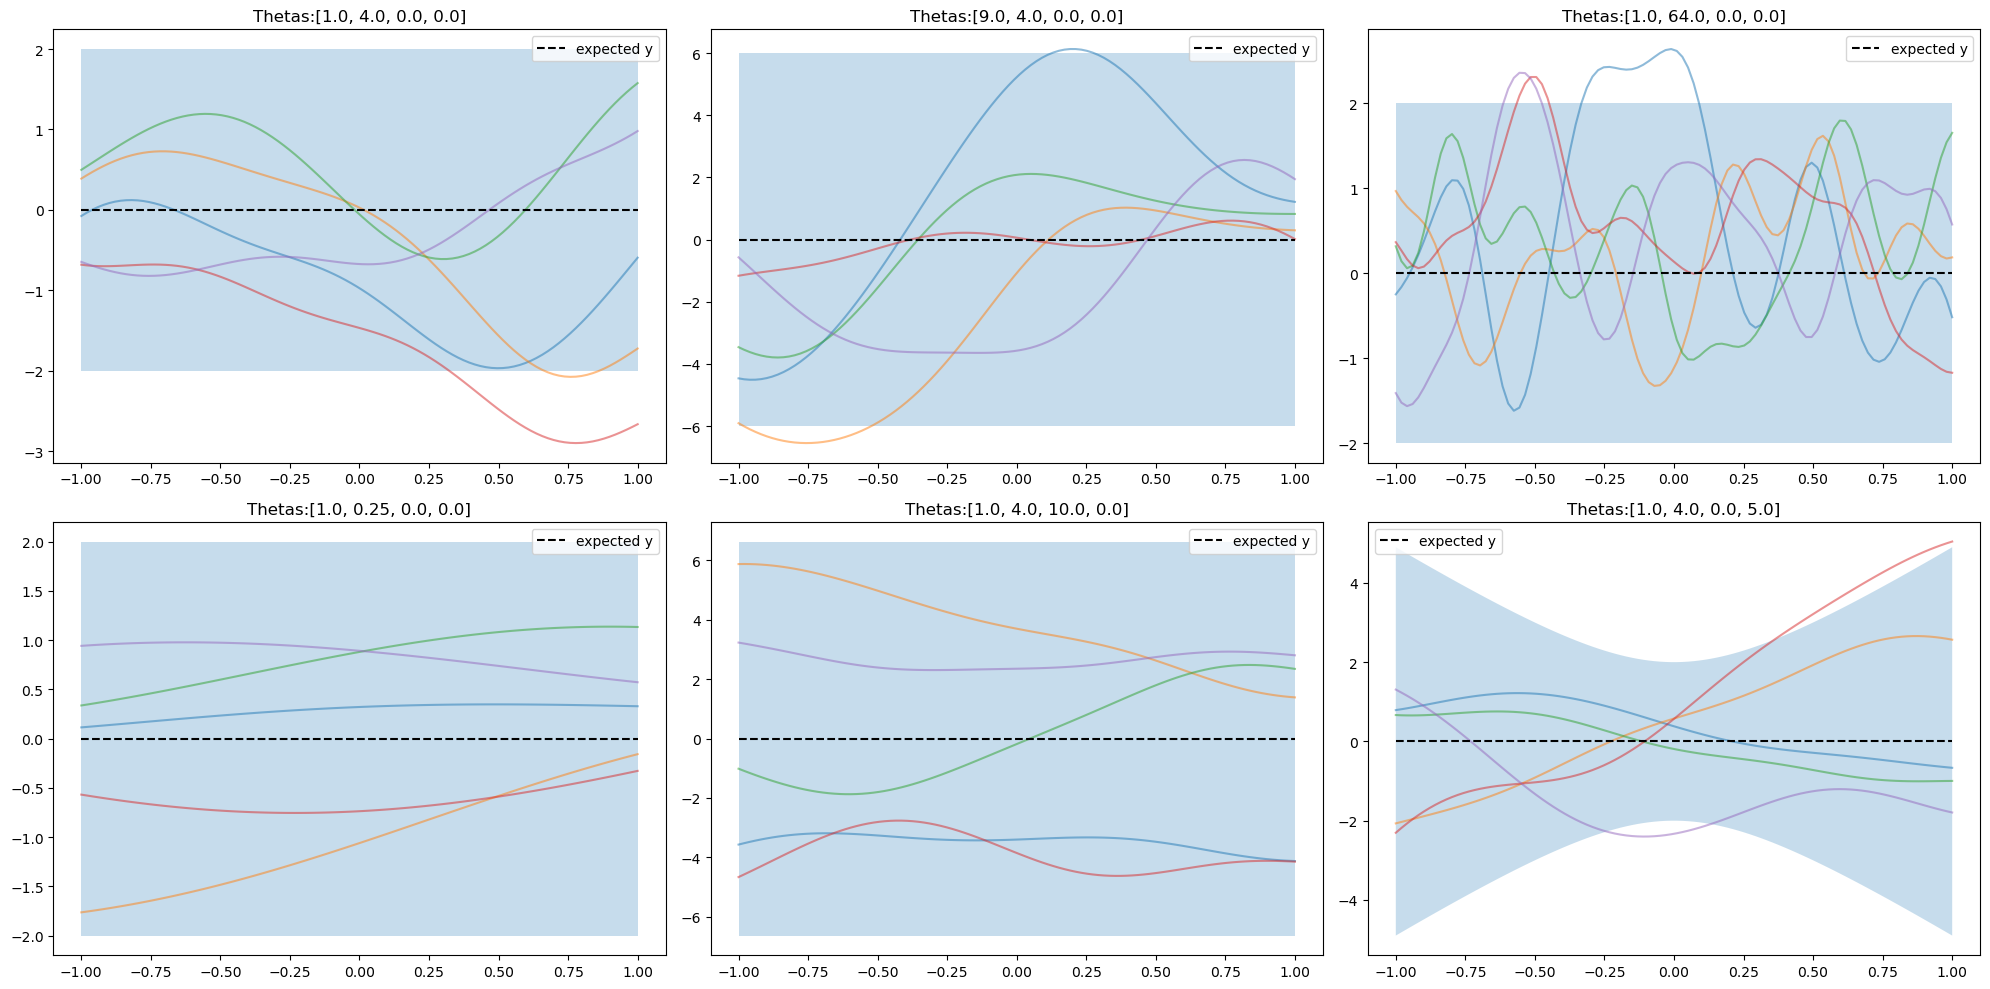

In [9]:

def plot_function_samples(x, y, Thetas):
    
    Thetas_x2 = Thetas + Thetas

    plt.figure()
    for i,thetas in enumerate(Thetas):
        K = computeK(x, x, thetas)


        eigvals, eigvecs = np.linalg.eig(K) # eigendecomposition of the Gram matrix
        L, U = np.diag((eigvals)), eigvecs
        A = np.matmul(U,L**(1/2)) # creating the matrix for reparametrizaion trick

        plt.subplot(231+i)
        plt.title(f'Thetas:{thetas}')

        expected_y = np.zeros((len(x)))

        mean_y = np.zeros((N_test))
        n_samples = 5
        for j in range(n_samples):
            z = random.multivariate_normal(np.zeros((N_test)), np.eye(N_test))
            y = A.dot(z)
            mean_y = np.add(mean_y, y)
            plt.plot(x, y, alpha=0.5)
        
        mean_y = (1/n_samples) * mean_y
        
        upper = np.zeros(len(x)) + 2 * np.sqrt(diag(K))
        lower = np.zeros(len(x)) - 2 * np.sqrt(diag(K))
        plt.plot(x,expected_y, '--', label='expected y',color='black')
        plt.fill_between(x_test, lower, upper, alpha=0.25)
    
        plt.legend()
    plt.tight_layout()
    plt.show()
        


Thetas = [[1.00,4.00,0.00,0.00], # first row
          [9.00,4.00,0.00,0.00],
          [1.00,64.00,0.00,0.00],
          [1.00,0.25,0.00,0.00], # second row
          [1.00,4.00,10.00,0.00],
          [1.00,4.00,0.00,5.00]]


plot_function_samples(x_test,y_test, Thetas)




### 2. Predictive distribution (35 points)
So far we have sampled mean functions from the prior.  We can draw actual data $\bt$ two ways.  The first way is generatively, by first sampling $\by | \mathbf{K}$, then sampling $\bt | \by, \beta$ (Eqns 6.60 followed by 6.59).  The second way is to integrate over $\by$ (the mean draw) and directly sample $\bt | \mathbf{K}, \beta$ using Eqn 6.61.    This is the generative process for $\bt$.  Note that we have not specified a distribution over inputs $\bx$;  this is because Gaussian processes are conditional models.  Because of this we are free to generate locations $\bx$ when playing around with the GP; obviously a dataset will give us input-output pairs.

Once we have data, we are interested in the predictive distribution (note: the prior is the predictive distribution when there is no data).  Consider the joint distribution for $N+1$ targets, given by Eqn 6.64.  Its covariance matrix is composed of block components $\mathbf{C}_N$, $\mathbf{k}$, and $c$.  The covariance matrix $\mathbf{C}_N$ for $\bt_N$ is $\mathbf{C}_N = \mathbf{K}_N + \beta^{-1}\mathbf{I}_N$.  We have just made explicit the size $N$ of the matrix; $N$ is the number of training points.  The kernel vector $\mathbf{k}$ is a $N$ by $1$ vector of kernel function evaluations between the training input data and the test input vector.  The scalar $c$ is a kernel evaluation at the test input.

#### 2.1 gp_predictive_distribution(...) (10 points)
Write a function `gp_predictive_distribution(x_train, t_train, x_test, theta, beta, C=None)` that computes  Eqns 6.66 and 6.67, except allow for an arbitrary number of test points (not just one) and now the kernel matrix is for training data. We have:

- $\mathbf{K}$: $K_{n,m} = k(x_{\text{train},n}, x_{\text{train},m})$; $\mathbf{K}$ is a $N_\text{train}\times N_\text{train}$ matrix
- $\mathbf{C}$: $\mathbf{C} = \mathbf{K} + \beta^{-1}\mathbf{I}$; $\mathbf{C}$ is a $N_\text{train}\times N_\text{train}$ matrix
- $\mathbf{k}$: $k_{n,m} = k(x_{\text{train},n}, x_{\text{test},m})$; $\mathbf{k}$ is a $N_\text{train}\times N_\text{test}$ matrix
- $\mathbf{c}$: $c_{n,m} = k(x_{\text{test},n}, x_{\text{test},m}) + \beta^{-1}$ if $n=m$ and $0$ otherwise; $\mathbf{c}$ is a $N_\text{test}\times N_\text{test}$ matrix

Now Eqns 6.66 and 6.67  become
- $\mu = \mathbf{k}^T\mathbf{C}^{-1}\mathbf{t}$; $\mu$ is a vector of length $N_\text{test}$
- $\Sigma = \mathbf{c} - \mathbf{k}^T\mathbf{C}^{-1}\mathbf{k}$; $\Sigma$ is a $N_\text{test}\times N_\text{test}$ matrix

Last, the standard deviation for every data point in the test vector $x_{\text{test}}$ is given by

- $\sigma = \sqrt{\text{diag}(\Sigma)}$,

where $\sigma$ is a vector of length $N_\text{test}$.


By having C as an optional parameter in the function we can avoid computing it more than once (for this problem it is unimportant, but for real problems this is an issue).  The function should compute $\mathbf{C}$, $\mathbf{k}$, and return the mean, standard deviation and $\mathbf{C}$.(10 points)

In [10]:
def gp_predictive_distribution(x_train, t_train, x_test, theta, beta, C=None):

    if not any(C):
        K = computeK(x_train, x_train, theta)
        C = K + 1/beta*np.eye(K.shape[0])


    k = computeK(x_train, x_test, theta)

    c = np.diag(np.diag(computeK(x_test,x_test, theta))) + 1/beta*np.eye(len(x_test))

    mean_test = k.T.dot(np.linalg.inv(C)).dot(t_train)

    Sigma = c - k.T.dot(np.matmul(np.linalg.inv(C),k))

    std_test = np.sqrt(np.diag(Sigma))

    
    return mean_test, std_test, C


In [11]:
### Test your function
# The RuntimeWarning: invalid value encountered in sqrt is to be expected!

N = 2
train_x = np.linspace(-1, 1, N)
train_t = 2*train_x
test_N = 3
test_x = np.linspace(-1, 1, test_N) 
theta = [1, 2, 3, 4]
beta = 25
test_mean, test_std, C = gp_predictive_distribution(train_x, train_t, test_x, theta, beta, C=None)

print(test_std)

assert test_mean.shape == (test_N,), "the shape of mean is incorrect"
assert test_std.shape == (test_N,), "the shape of var is incorrect"
assert C.shape == (N, N), "the shape of C is incorrect"

C_in = np.array([[0.804, -0.098168436], [-0.098168436, 0.804]])
_, _, C_out = gp_predictive_distribution(train_x, train_t, test_x, theta, beta, C=C_in)

assert np.allclose(C_in, C_out), "C is not reused!"


[0.28248537 0.90886121 0.28248537]


/tmp/ipykernel_69826/950199462.py:16: RuntimeWarning: invalid value encountered in sqrt
  std_test = np.sqrt(np.diag(Sigma))


#### 2.2 gp_log_likelihood(...) (10 points)
To learn the hyperparameters, we would need to compute the log-likelihood of the of the training data.  Implicitly, this is conditioned on the value setting for $\mathbf{\theta}$.  Write a function `gp_log_likelihood(x_train, t_train, theta, C=None, invC=None, beta)`, where C and invC can be stored and reused. It should return the log-likelihood, `C` and `invC`  (10 points)

In [12]:
def gp_log_likelihood(x_train, t_train, theta, beta, C=None, invC=None):
    
    K = computeK(x_train, x_train, theta)

    if not any(C):
        C = K + 1/beta*np.eye(K.shape[0])
    
    if not any(invC):
        if not any(C):
            C = K + 1/beta*np.eye(K.shape[0])
        invC = np.linalg.inv(C)


    # equation 6.69
    ll = -0.5*np.log(np.linalg.det(C)) - 0.5*t_train.T.dot(np.linalg.inv(C)).dot(t_train) - (len(t_train)/2)*np.log(2*np.pi) 
    
    return ll, C, invC

In [13]:
### Test your function
N = 2
train_x = np.linspace(-1, 1, N)
train_t = 2 * train_x
theta = [1, 2, 3, 4]
beta = 25
lp, C, invC = gp_log_likelihood(train_x, train_t, theta, beta, C=None, invC=None)

assert lp < 0, "the log-likelihood should be smaller than 0"
assert C.shape == (N, N), "the shape of var is incorrect"
assert invC.shape == (N, N), "the shape of C is incorrect"

C_in = np.array([[0.804, -0.098168436], [-0.098168436, 0.804]])
_, C_out, _ = gp_log_likelihood(train_x, train_t, theta, beta, C=C_in, invC=None)

assert np.allclose(C_in, C_out), "C is not reused!"

invC_in = np.array([[1.26260453, 0.15416407], [0.15416407, 1.26260453]])
_, _, invC_out = gp_log_likelihood(train_x, train_t, theta, beta, C=None, invC=invC_in)

assert np.allclose(invC_in, invC_out), "invC is not reused!"


#### 2.3 Plotting (10 points)
Repeat the 6 plots above, but this time conditioned on the training points.  Use the periodic data generator to create 2 training points where x is sampled uniformly between $-1$ and $1$.  For these plots, feel free to use the provided function "gp_plot".  Make sure you put the parameters in the title and this time also the log-likelihood. Try to understand the two types of uncertainty!  If you do not use `gp_plot(...)`, please add a fill between for the model and target noise. (10 points)

In [14]:
def gp_plot( x_test, y_test, mean_test, std_test, x_train, t_train, theta, beta ):
    # x_test: 
    # y_test:    the true function at x_test
    # mean_test: predictive mean at x_test
    # var_test:  predictive covariance at x_test 
    # t_train:   the training values
    # theta:     the kernel parameters
    # beta:      the precision (known)
    
    # the reason for the manipulation is to allow plots separating model and data stddevs.      # includes all uncertainty, model and target noise 
    std_model = np.sqrt(std_test**2 - 1.0/beta)  # remove data noise to get model uncertainty in stddev
    std_combo = std_model + np.sqrt(1.0/beta)    # add stddev (note: not the same as full)
    
    plt.plot(x_test, y_test, 'b', lw=3)
    plt.plot(x_test, mean_test, 'k--', lw=2)
    plt.fill_between(x_test, mean_test+2*std_combo,mean_test-2*std_combo, color='k', alpha=0.25)
    plt.fill_between(x_test, mean_test+2*std_model,mean_test-2*std_model, color='r', alpha=0.25)
    plt.plot(x_train, t_train, 'ro', ms=10)


    # some edits for repeated plotting
    plt.title(f'Thetas: {theta}, L: {log_like}')

    

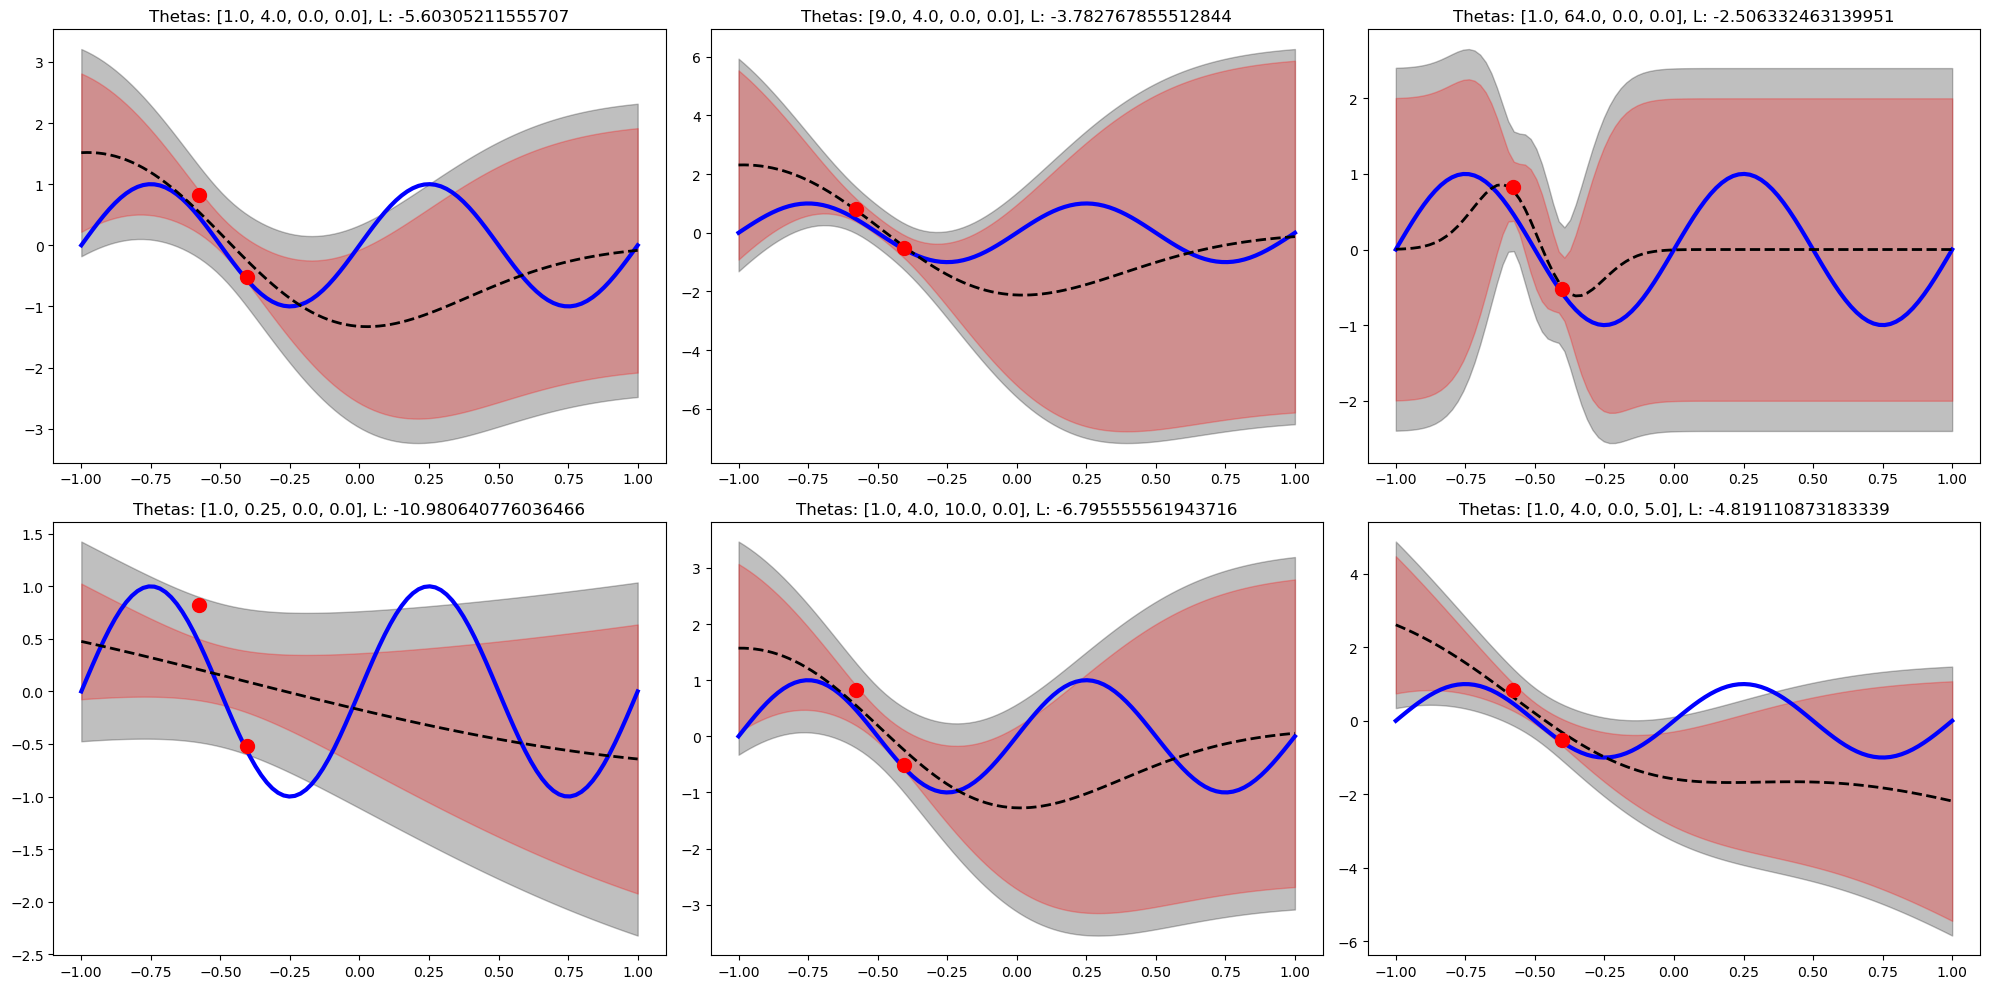

In [15]:
N_train = 2
x_train = np.random.uniform(-1,1,N_train)
t_train = generate_t(x_train, sigma)


# plotting
plt.figure()
for i, theta in enumerate(Thetas):
    plt.subplot(231+i)
    mean_test, std_test, C = gp_predictive_distribution(x_train, t_train, x_test, theta, beta)
    log_like, C,invC = gp_log_likelihood(x_train, t_train,theta, beta, C=C)
    gp_plot(x_test, y_test, mean_test, std_test, x_train, t_train, theta, beta)
    plt.tight_layout()


#### 2.4 More plotting (5 points)
Repeat the 6 plots above, but this time conditioned a new set of 10 training points. (5 points)

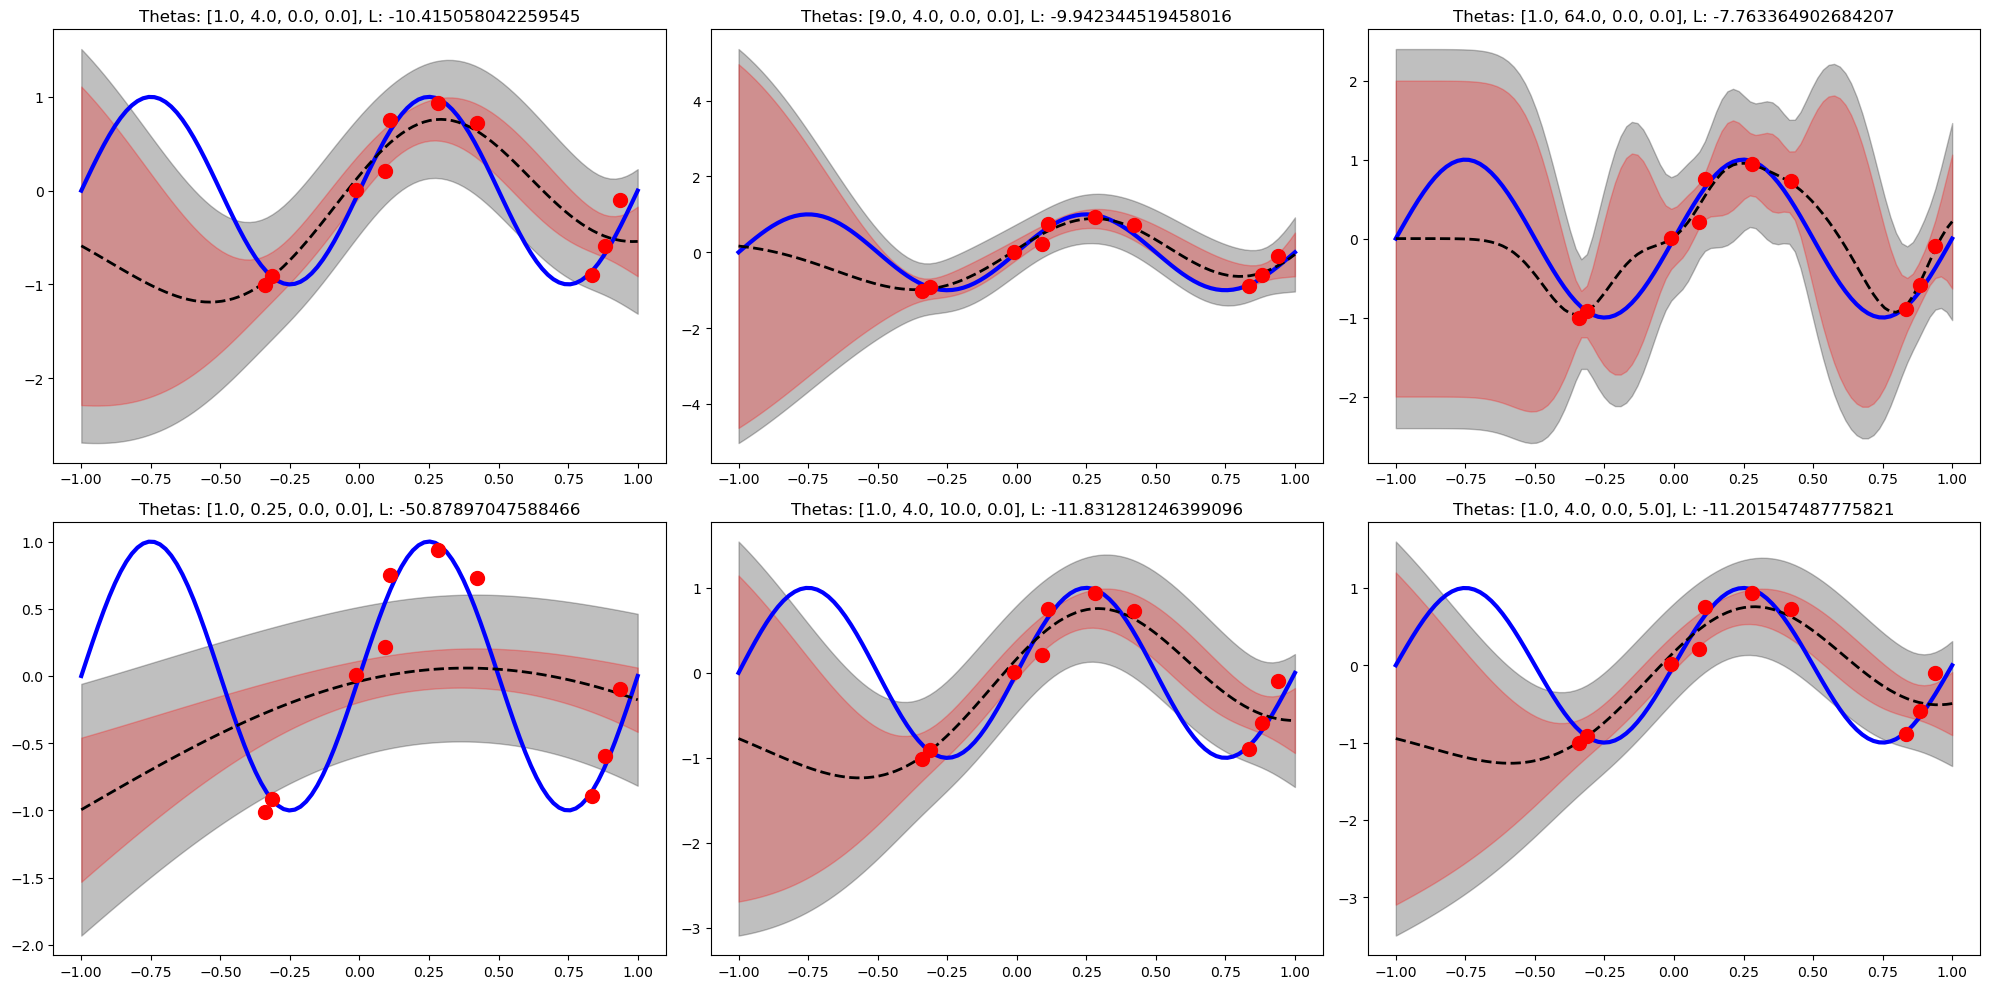

In [16]:
from sklearn.covariance import log_likelihood


N_train = 10
x_train = np.random.uniform(-1,1,N_train)
t_train = generate_t(x_train, sigma)


# plotting
plt.figure()
for i, theta in enumerate(Thetas):
    plt.subplot(231+i)
    mean_test, std_test, C = gp_predictive_distribution(x_train, t_train, x_test, theta, beta)
    log_like, C,invC = gp_log_likelihood(x_train, t_train,theta, beta, C=C)
    gp_plot(x_test, y_test, mean_test, std_test, x_train, t_train, theta, beta)
    plt.tight_layout()
